# Seed

In [1]:
import random
import torch
import numpy as np

In [2]:
def seed_everything(seed=5):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# DataSet

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [4]:
cat_image_path = "../data/cifar10_images/cat"
dog_image_path = "../data/cifar10_images/dog"

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dir_paths, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform

        for dir_path in dir_paths:
            label = os.path.basename(dir_path)
            for file_name in os.listdir(dir_path):
                image_path = os.path.join(dir_path, file_name)
                image = Image.open(image_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                self.images.append(image)
                self.labels.append(label)

        self.label_to_index = {'cat': 0, 'dog': 1}
        self.labels = [self.label_to_index[label] for label in self.labels]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

In [7]:
dataset = CustomDataset(dir_paths=[cat_image_path, dog_image_path], transform=test_transform)

print(f"number of dataset: {len(dataset)}")

number of dataset: 1000


In [8]:
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

print(f"number of train dataset: {len(train_dataset)}")
print(f"number of valid dataset: {len(valid_dataset)}")
print(f"number of test dataset: {len(test_dataset)}")

number of train dataset: 700
number of valid dataset: 150
number of test dataset: 150


In [9]:
train_dataset.dataset.transform = train_transform

In [10]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for image, label in train_loader:
    print(f"data shape: {image.size()}")
    print(f"label shape: {label.size()}")
    break

data shape: torch.Size([16, 3, 32, 32])
label shape: torch.Size([16])


# HyperParameter

In [11]:
input_size = 32 * 32 * 3
hidden_size = 128
learning_rate = 0.0001
num_epochs = 100
weight_decay = 1e-4

# Weight Initalize

In [12]:
import torch.nn as nn

In [13]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Model

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_classes, dropout_prob=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)  # Adjust input size based on the feature map size
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Example usage:
input_channels = 3  # For RGB images
num_classes = 1  # Binary classification
dropout_prob = 0.5

model = SimpleCNN(input_channels=input_channels, num_classes=num_classes, dropout_prob=dropout_prob)

In [15]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())

    return total_params

def print_model_parameters(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.numel()} parameters")
    print(f"Total parameters: {count_parameters(model)}")

print_model_parameters(model)

conv1.weight: 432 parameters
conv1.bias: 16 parameters
conv2.weight: 4608 parameters
conv2.bias: 32 parameters
fc1.weight: 131072 parameters
fc1.bias: 64 parameters
fc2.weight: 64 parameters
fc2.bias: 1 parameters
Total parameters: 136289


# Loss

In [16]:
criterion = nn.BCELoss()

# Optimizer

In [17]:
import torch.optim as optim

In [18]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train

In [19]:
patience = 10
best_val_loss = float('inf')
patience_counter = 0
early_stopping_triggered = False

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        labels = labels.float().view(-1, 1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:

            labels = labels.float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

    val_epoch_loss = val_running_loss / len(valid_loader.dataset)
    valid_losses.append(val_epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered. Stopping training after epoch {epoch + 1}.')
        early_stopping_triggered = True
        plot_epoch = epoch + 2
        break

if not early_stopping_triggered:
    print(f'Finished training after {num_epochs} epochs.')
else:
    print(f'Training stopped early after {epoch + 1} epochs.')

Epoch 1/100, Loss: 0.6943
Epoch 1/100, Validation Loss: 0.6920
Epoch 2/100, Loss: 0.6924
Epoch 2/100, Validation Loss: 0.6931
Epoch 3/100, Loss: 0.6929
Epoch 3/100, Validation Loss: 0.6919
Epoch 4/100, Loss: 0.6919
Epoch 4/100, Validation Loss: 0.6947
Epoch 5/100, Loss: 0.6892
Epoch 5/100, Validation Loss: 0.6882
Epoch 6/100, Loss: 0.6923
Epoch 6/100, Validation Loss: 0.6931
Epoch 7/100, Loss: 0.6890
Epoch 7/100, Validation Loss: 0.6835
Epoch 8/100, Loss: 0.6871
Epoch 8/100, Validation Loss: 0.6810
Epoch 9/100, Loss: 0.6877
Epoch 9/100, Validation Loss: 0.6869
Epoch 10/100, Loss: 0.6818
Epoch 10/100, Validation Loss: 0.6749
Epoch 11/100, Loss: 0.6800
Epoch 11/100, Validation Loss: 0.6775
Epoch 12/100, Loss: 0.6791
Epoch 12/100, Validation Loss: 0.6705
Epoch 13/100, Loss: 0.6793
Epoch 13/100, Validation Loss: 0.6642
Epoch 14/100, Loss: 0.6737
Epoch 14/100, Validation Loss: 0.6580
Epoch 15/100, Loss: 0.6618
Epoch 15/100, Validation Loss: 0.6615
Epoch 16/100, Loss: 0.6606
Epoch 16/100, Va

In [20]:
import matplotlib.pyplot as plt

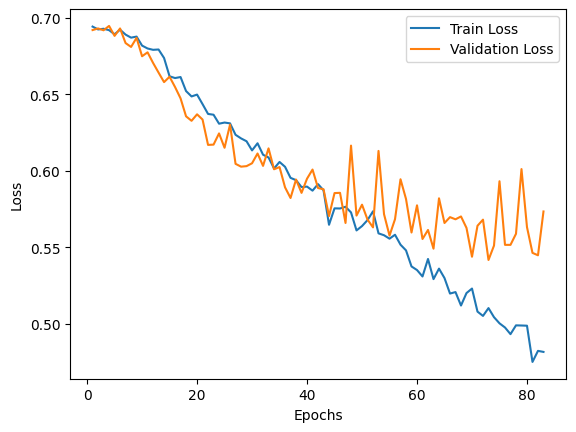

In [21]:
plt.plot(range(1, plot_epoch), train_losses, label='Train Loss')
plt.plot(range(1, plot_epoch), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict

In [22]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.float().view(-1, 1)

        outputs = model(images)

        predicted = (outputs > 0.5).float()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

Test Set Accuracy: 63.33%
